# 1 Introduction

Welcome to the ninth practical session of CS233 - Introduction to Machine Learning.  
In this exercise class we will start using Machine Learning methods to solve regression problems.

In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 2 Regression Problem

Let $f$ be a function $f: \mathbb{R}^d \rightarrow \mathbb{R}^v$ with a data set $\left(X \subseteq \mathbb{R}^d, y
\subseteq\mathbb{R}^v \right )$. The regression problem is the task of estimating an approximation $\hat{f}$ of $f$.
Within this exercise we consider the special case of $v=1$, i.e. the problem is univariate as opposed to multivariate.
Specifically, we will analyze the Boston house prices data set and predict costs based on properties such as per capita crime rate by town, pupil-teacher ratio by town etc.

We will model the given data by means of a linear regression model, i.e. a model that explains a dependent variable in terms of a linear combination of independent variables.

- How does a regression problem differ from a classification problem?
    - A classification problem has discrete-valued target variables, whereas the values of target variables in regression problems may be continuous.
- Why is the linear regression model a linear model? Is it linear in the dependent variables? Is it linear in the parameters?
    - The linear regression model is linear in the parameters.

# 2.1 Load and inspect data

We load the data and split it such that 80% and 20% are train and test data, respectively. 
After, we normalize the data such that each feature has zero mean and unit standard deviation. Please fill in the required code and complete the function `normalize`.

- Explore the relation between different features and the house prices. Describe what you see. Can you identify any trends?
    - The relations between feature values and house prices differ between feature dimensions. Some features (e.g. 4) are positively correlated with house prices, some (e.g. 11) are negatively correlated and for many others a clear trend is hard to spot by mere inspection.

In [3]:
# get the data set and print a description
from sklearn.datasets import load_boston
boston_dataset = load_boston()
print(boston_dataset.DESCR)

X = boston_dataset["data"]
y = boston_dataset["target"]

# remove categorical feature
X = np.delete(X, 3, axis=1)
# removing second mode
ind = y<40
X = X[ind,:]
y = y[ind]

# split the data into 80% training and 20% test data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

splitRatio = 0.8
n          = X.shape[0]
X_train    = X[indices[0:int(n*splitRatio)],:] 
y_train    = y[indices[0:int(n*splitRatio)]] 
X_test     = X[indices[int(n*(splitRatio)):],:] 
y_test     = y[indices[int(n*(splitRatio)):]] 

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
'''
Make mean 0 and std dev 1 of the data.
'''
def normalize(X):
    """
    Please fill in the required code here
    """
    
    mu    = np.mean(X,0,keepdims=True)
    std   = np.std(X,0,keepdims=True) 
    X     = (X-mu)/std
    return X, mu, std

#Use train stats for normalizing test set
X_train,mu_train,std_train = normalize(X_train)
X_test = (X_test-mu_train)/std_train

Text(0.5, 1.0, 'Attribute $X_4$ vs Price $y$')

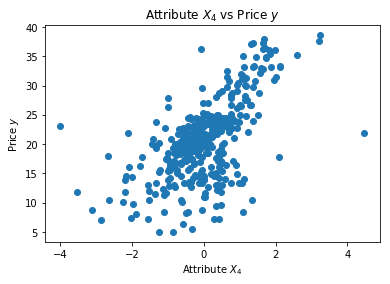

In [5]:
# Exploratory analysis of the data. Have a look at the distribution of prices vs features

feature = 4
plt.scatter(X_train[:,feature], y_train)
plt.xlabel(f"Attribute $X_{feature}$")
plt.ylabel("Price $y$")
plt.title(f"Attribute $X_{feature}$ vs Price $y$")

# 2.2 Closed-form solution for linear regression

The linear regression model has an [analytical solution](https://en.wikipedia.org/wiki/Linear_least_squares). 
Please use this solution to complete the function `get_w_analytical` and to obtain the weight parameters $w$. Tip: You may want to use the function np.linalg.solve. 

- What is the time complexity of this approach?
    - Let N be the number of data points. The time complexity is determined by the slowest operation, i.e. the matrix inversion, which is in $\mathcal{O}(N^3)$.

In [6]:
def get_w_analytical(X_train,y_train):
    """
    compute the weight parameters w
    """
    
    """
    Please fill in the required code here
    """
        
    # compute w via the normal equation
    # np.linalg.solve is more stable than np.linalg.inv
    w = np.linalg.solve(X_train.T@X_train,X_train.T@y_train)
    return w

def get_loss(w, X_train, y_train,X_test,y_test,val=False):
    # predict dependent variables and MSE loss for seen training data
    """
    Please fill in the required code here
    """
    loss_train = (np.mean((y_train-X_train@w)**2))
    loss_train_std = np.std((y_train-X_train@w)**2)
    
    # predict dependent variables and MSE loss for unseen test data
    """
    Please fill in the required code here
    """
    loss_test = (np.mean((y_test-X_test@w)**2))
    loss_test_std = np.std((y_test-X_test@w)**2)
    if not val:
        print("The training loss is {} with std:{}. The test loss is {} with std:{}.".format(loss_train, loss_train_std, loss_test,loss_test_std))
    else:
        print("The training loss is {} with std:{}. The val loss is {} with std:{}.".format(loss_train, loss_train_std, loss_test,loss_test_std))

    return loss_test


In [7]:
# compute w and calculate its goodness
w_ana = get_w_analytical(X_train,y_train)
get_loss(w_ana, X_train,y_train, X_test,y_test)

The training loss is 436.8437185477003 with std:142.73673671586107. The test loss is 437.3294638920944 with std:148.94707784497865.


437.3294638920944

###### 2.3 Feature expansion

Similar to feature expansion for classification problems, we can also perform feature expansion here. Please complete the function `expand_X` and perform a degree-2 polynomial feature expansion of X, including a bias term but omitting interaction terms.

- Is our model still a linear regression model? Why (not)?
    - Yes, our model is still a linear regression model because it is still linear in the parameters.
- How does linear regression on degree-2 polynomially expanded data compare against our previous model? Explain!
    - The model performs better on the degree-2 polynomially expanded data as compared to the previous model.
- Try polynomial feature expansion for different parameters values of $d$. What do you observe? Explain!
    - The model improves in performance up to degree-5 polynomial feature expansion, after which the training loss still decreases but the test loss increases again. This is due to overfitting.
- Look up the concept of the [condition number of a matrix](https://blogs.mathworks.com/cleve/2017/07/17/what-is-the-condition-number-of-a-matrix/). What does this tell us about the feature-expanded data?
    - The inverse condition number of a function is a measure of how much the function is sensitive to changes in its input. Functions with a large-condition number are said to be ill-conditioned and may cause our methods to deal with numerical inaccuracies. A polynomial feature expansion of a higher degree results in a larger condition number and will lead to inaccurate inverse calculation.

In [7]:
def expand_X(X,d):
    """
    perform degree-d polynomial feature expansion of X, with bias but omitting interaction terms
    """
    
    """
    Please fill in the required code here
    """
    
    expand = np.ones((X.shape[0],1))
    for idx in range(1,d+1): expand=np.hstack((expand, X**idx))
    return expand

In [8]:
def expand_and_normalize_X(X,d):
    """
    perform degree-d polynomial feature expansion of X, with bias but omitting interaction terms
    and normalize them.
    """
    
    """
    Please fill in the required code here
    """
    expand = expand_X(X,d)
    expand_withoutBias,mu,std = normalize(expand[:,1:])
    expand[:,1:] = expand_withoutBias
    return expand, mu, std

In [9]:
# perform polynomial feature expansion
d = 2

#normalize the data after expansion
X_train_poly,mu_train_poly,std_train_poly = expand_and_normalize_X(X_train,d)
X_test_poly  = expand_X(X_test,d)
X_test_poly[:,1:]  = (X_test_poly[:,1:]-mu_train_poly)/std_train_poly


print("The original data has {} features.".format(X_train.shape[1]))
print("After degree-{} polynomial feature expansion (with bias, without interaction terms) the data has {} features.".format(d,X_train_poly.shape[1]))

cond_num_before = np.linalg.cond(X_train.T@X_train)
cond_num_after = np.linalg.cond(X_train_poly.T@X_train_poly)
print("The original data X^TX has condition number {}. \nThe expanded data X^TX has condition number {}.".format(cond_num_before,cond_num_after))

# re-compute w and calculate its goodness
w_augm = get_w_analytical(X_train_poly,y_train)
get_loss(w_augm, X_train_poly,y_train, X_test_poly,y_test)

The original data has 12 features.
After degree-2 polynomial feature expansion (with bias, without interaction terms) the data has 25 features.
The original data X^TX has condition number 94.30540153557189. 
The expanded data X^TX has condition number 304.6821566696805.
The training loss is 8.146544587369405 with std:18.14451706916919. The test loss is 8.577004357720213 with std:13.4943321035368.


8.577004357720213

In above exercise, we directly evaluate model on test loss and choose the best degree of polynomial. But test should not be touched until your final model. So to choose best degree we'll use Cross Validation. We're going to K-Fold CV for that. We will use our training set and create K splits of it to choose best degree and finally evaluate on our test set.


In [10]:
# Function for using kth split as validation set to get loss
# and k-1 splits to train our model
# k = kth fold
# k_fold_ind = all the fold indices
# X,Y= train data and labels
# degree = degree of polynomial expansion

def do_cross_validation(k,k_fold_ind,X,Y,degree=1):
    
    # use one split as val
    val_ind = k_fold_ind[k]
    # use k-1 split to train
    train_splits = [i for i in range(k_fold_ind.shape[0]) if i is not k]
    train_ind = k_fold_ind[train_splits,:].reshape(-1)
    
    #Get train and val 
    cv_X_train = X[train_ind,:]
    cv_Y_train = Y[train_ind]
    cv_X_val = X[val_ind,:]
    cv_Y_val = Y[val_ind]

    #expand and normalize for degree d
    cv_X_train_poly,mu,std = expand_and_normalize_X(cv_X_train,degree)
    #apply the normalization using statistics (mean, std) computed on train data
    cv_X_val_poly = expand_X(cv_X_val,degree)
    cv_X_val_poly[:,1:] =  (cv_X_val_poly[:,1:]-mu)/std
    
    #fit on train set
    w = get_w_analytical(cv_X_train_poly,cv_Y_train)
    
    #get loss for val
    loss_test = get_loss(w,cv_X_train_poly,cv_Y_train,cv_X_val_poly,cv_Y_val,val=True)
    return loss_test


Let's do 3-fold CV

In [11]:
from helper import fold_indices
k_fold=3

# We create the k_fold splits of the train data
num_train_examples = X_train.shape[0]
fold_ind = fold_indices(num_train_examples,k_fold)

In [12]:
from helper import grid_search_cv

# put the list of degree values to be evaluated
search_degree = np.arange(1,15)
params={'degree':search_degree}

#call to the grid search function
grid_val,grid_val_std = grid_search_cv(params,k_fold,fold_ind,do_cross_validation,X_train,y_train)

Evaluating for {'degree': 1} ...
The training loss is 9.878733332550935 with std:18.37782618122855. The val loss is 12.097836086985499 with std:17.127104767852995.
The training loss is 11.399153182137644 with std:21.252737552838692. The val loss is 8.642850525165404 with std:13.217410675430829.
The training loss is 9.647515495078757 with std:14.163330615094118. The val loss is 12.361915261420615 with std:29.5120132938108.
Evaluating for {'degree': 2} ...
The training loss is 6.704434095012012 with std:13.04290453803446. The val loss is 15.33226377128941 with std:59.194356689515615.
The training loss is 8.59812312387266 with std:19.20966159118811. The val loss is 7.99215021511865 with std:12.953280974968997.
The training loss is 8.295107830537537 with std:13.781793734479015. The val loss is 8.952202411127612 with std:18.538578865584697.
Evaluating for {'degree': 3} ...
The training loss is 6.016961518016398 with std:12.98640668859862. The val loss is 219.9763051196828 with std:2147.1993

Observe how the validation score decreases and then increases with degree

In [13]:
#get the best validation score
best_score = np.min(grid_val)
print('Best val score {}'.format(best_score))

#get degree which gives best score
best_degree = search_degree[np.argmin(grid_val)]
print('Best val score for degree {}'.format(best_degree))


X_train_poly,mu,std = expand_and_normalize_X(X_train,best_degree)
w = get_w_analytical(X_train_poly,y_train)
X_test_poly = expand_X(X_test,best_degree)
X_test_poly[:,1:] =  (X_test_poly[:,1:]-mu)/std

get_loss(w,X_train_poly,y_train,X_test_poly,y_test)

Best val score 10.758872132511891
Best val score for degree 2
The training loss is 8.146544587369405 with std:18.14451706916919. The test loss is 8.577004357720213 with std:13.4943321035368.


8.577004357720213

# 2.3 Numerical solution for linear regression


The linear regression model has an analytical solution, but we can also get the weight parameters $w$ numerically, e.g. via stochastic gradient descent. Please use this approach to complete the function `get_w_numerical` below.

- How do these results compare against those of the analytical solution? Explain the differences or similarities!
    - The analytical solution and the numerical solution are almost identical. But when condition number of matrix is
    very high inverse may not be stable and solution will differ.
- In which cases, it maybe be preferable to use the numerical approach over the analytical solution?
    - Let N be the number of data points. Computing the analytical solution has run time $\mathcal{O}(N^3)$, which may be problematic if N is very large.

In [14]:
def get_w_numerical(X_train,y_train,X_test_poly,y_test,epochs,lr):
    """compute the weight parameters w"""
    
    """
    Please fill in the required code here
    """
    
    # initialize the weights
    w    = np.random.normal(0, 1e-1, X_train.shape[1])
    # define the gradient
    grad = lambda w,x,y: (y-x@w)*x
    
    # iterate a given number of epochs over the training data
    for epoch in range(epochs):
        
        # iterate over each data point
        for idx,x_train in enumerate(X_train):
            # update the weights
            w += lr*grad(w,x_train,y_train[idx])
            
        if epoch % 1000 == 0:
            print(f"Epoch {1000+epoch}/{epochs}")
            get_loss(w, X_train_poly,y_train, X_test_poly,y_test)
            
    return w

In [15]:
# compute w and calculate its goodness
X_train_poly,mu,std = expand_and_normalize_X(X_train,best_degree)
X_test_poly = expand_X(X_test,best_degree)
X_test_poly[:,1:] =  (X_test_poly[:,1:]-mu)/std
w_num = get_w_numerical(X_train_poly,y_train,X_test_poly,y_test,15000,8*1e-5)

Epoch 1000/15000
The training loss is 438.82197783111553 with std:269.70024898557244. The test loss is 487.795755682178 with std:288.0750855084646.
Epoch 2000/15000
The training loss is 8.236056562702556 with std:18.501123209527982. The test loss is 9.137317350004377 with std:14.55992640535479.
Epoch 3000/15000
The training loss is 8.16167686880121 with std:18.180565642719948. The test loss is 8.822776407838896 with std:14.025521070509464.
Epoch 4000/15000
The training loss is 8.149433149908623 with std:18.106098455220362. The test loss is 8.687750036374553 with std:13.741249494747919.
Epoch 5000/15000
The training loss is 8.147175969113508 with std:18.08255403686697. The test loss is 8.629587660944399 with std:13.607602247208229.
Epoch 6000/15000
The training loss is 8.146733506632511 with std:18.074171654432142. The test loss is 8.604089986700975 with std:13.546077110524106.
Epoch 7000/15000
The training loss is 8.146642412498348 with std:18.07097230682923. The test loss is 8.5928117

We can also use the sklearn implementation of the linear regression model. Please look up the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to 

1. instantiate the LinearRegression model
2. fit the model to our training data
3. evaluate the model on the test data
4. and compare the results with our previous outcomes

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

"""
Please fill in the required code here
"""
    
model = LinearRegression()
model.fit(X_train_poly,y_train)
y_hat = model.predict(X_test_poly)

print('MSE of sklearn linear regression model on test data: ' , metrics.mean_squared_error(y_test,y_hat))

MSE of sklearn linear regression model on test data:  8.577004357720154


# 2.4 Ridge Regression


As seen in previous section, we would like to do feature expansion to fit the non-linearity of the data, but it soon leads to overfitting. There are different ways to tackle this problem, like getting more data, changing the prediction method, regularization, etc. For the task of regression, we'll add a regularization to our training objective to mitigate this problem. Intutively, regularization restricts the domain from which the values of model parameters are taken, which means that we are biasing our model.  

In Ridge Regression, we restrict the $l_2$ norm of the coefficients $\mathbf{w}$. Our loss function looks as following,
\begin{align}
L(\mathbf{w}) &=\frac{1}{N} \| \mathbf{y} - \mathbf{X}\mathbf{w} \|^2 + \frac{\lambda}{N}\|\mathbf{w}\|^2 \\
\nabla L(\mathbf{w}) &= -\frac{2}{N}\mathbf{X}^T(\mathbf{y} - \mathbf{X}\mathbf{w}) + 2\frac{\lambda}{N}\mathbf{w}
\end{align}

$\nabla L(\mathbf{w}) = 0$ for minimum condition, we get

\begin{align}
\mathbf{w} &= (\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}
\end{align}

dimensions are following: $\mathbf{w}$ is $D\times1$; $\mathbf{y}$ is $N\times1$; $\mathbf{X}$ is $N\times D$; $\mathbf{I}$ is identity matrix of dimension $D \times D$ .

$\lambda$ is our penality term, also know as weight decay. By varying its value, we can allow biasing in our model.

**Question**:
When $\lambda$ is high, our model is more complex or less?

**Answer**:
High $\lambda$ penalises the norm term more, hence restricts the value $\mathbf{w}$ can have, rendering simpler model.

**Question**:
How will $\lambda$ affect inverse condition number of $\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I}$ ?

**Answer**:
$\lambda > 0$, decreases the condition number, hence more stable computations.
\begin{align}
\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I} &= \mathbf{U}\mathbf{S}\mathbf{U}^T + \lambda \mathbf{U}\mathbf{I}\mathbf{U}^T \\
\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I} &= \mathbf{U}[\mathbf{S}+\lambda\mathbf{I}]\mathbf{U}^T
\end{align}
if we have singular decomposition of $\mathbf{X}^T\mathbf{X}$ as $\mathbf{U}\mathbf{S}\mathbf{U}^T$, then the above steps show that eigenvalues of $\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I}$ are atleast $\lambda$, hence we are lifting the all the eigenvalues. 


In [17]:
def get_w_analytical_with_regularization(X_train,y_train,lmda):
    """compute the weight parameters w with ridge regression"""
    
    """
    Please fill in the required code here
    """
    #create lambda matrix 
    lmda_mat = lmda*np.eye(X_train.shape[1])
    # compute w via the normal equation
    # np.linalg.solve is more stable than np.linalg.inv
    w = np.linalg.solve(X_train.T@X_train+lmda_mat,X_train.T@y_train)
    return w

In [18]:
# perform polynomial feature expansion
d  = 14

#normalize the data after expansion
X_train_poly,mu_train_poly,std_train_poly = expand_and_normalize_X(X_train,d)
X_test_poly  = expand_X(X_test,d)
X_test_poly[:,1:]  = (X_test_poly[:,1:]-mu_train_poly)/std_train_poly


print("The original data has {} features.".format(X_train.shape[1]))
print("After degree-{} polynomial feature expansion (with bias, without interaction terms) the data has {} features.".format(d,X_train_poly.shape[1]))

cond_num_before = np.linalg.cond(X_train.T@X_train)
cond_num_after = np.linalg.cond(X_train_poly.T@X_train_poly)
print("The original data X^TX has condition number {}. \nThe expanded data X^TX has condition number {}.".format(cond_num_before,cond_num_after))

#choose lambda value
lmda = 2

#write the X^TX+\lambda*I matrix
A = X_train.T@X_train+lmda*np.eye(X_train.shape[1])
cond_num_ridge = np.linalg.cond(A)
print("The X^TX+lambda*I with lambda:{} has condition number {}".format(lmda,cond_num_ridge))


The original data has 12 features.
After degree-14 polynomial feature expansion (with bias, without interaction terms) the data has 169 features.
The original data X^TX has condition number 94.30540153557189. 
The expanded data X^TX has condition number 6.119085746825847e+17.
The X^TX+lambda*I with lambda:2 has condition number 87.29222508026365


See how the condition number has changed with regularization.

Cross Validation(CV) is used to choose value of $\lambda$. As seen in previous exercise, we will use K-fold CV.
We will use our training set and create K splits of it to choose best degree and corresponding $\lambda$ and finally evaluate on our test set.

In [19]:
# Function for using kth split as validation set to get accuracy
# and k-1 splits to train our model
def do_cross_validation_reg(k,k_fold_ind,X,Y,lmda=0,degree=1):
    
    # use one split as val
    val_ind = k_fold_ind[k]
    # use k-1 split to train
    train_splits = [i for i in range(k_fold_ind.shape[0]) if i is not k]
    train_ind = k_fold_ind[train_splits,:].reshape(-1)
   
    #Get train and val 
    cv_X_train = X[train_ind,:]
    cv_Y_train = Y[train_ind]
    cv_X_val = X[val_ind,:]
    cv_Y_val = Y[val_ind]
    
   
    #expand and normalize for degree d
    cv_X_train_poly,mu,std = expand_and_normalize_X(cv_X_train,degree)

    #apply the normalization using statistics (mean, std) computed on train data
    cv_X_val_poly = expand_X(cv_X_val,degree)
    cv_X_val_poly[:,1:] =  (cv_X_val_poly[:,1:]-mu)/std
    
    #fit on train set using regularised version
    w = get_w_analytical_with_regularization(cv_X_train_poly,cv_Y_train,lmda)
    
    #get loss for val
    loss_test = get_loss(w,cv_X_train_poly,cv_Y_train,cv_X_val_poly,cv_Y_val,val=True)
    print(loss_test,lmda,degree)
    return loss_test

Let's do 3-fold CV. We will use same the training data splits as in non regularised case for fairer comparison.

In [20]:
#list of lambda values to try.. use np.logspace
search_lambda = np.logspace(-2,1,num=27)
#list of degrees
search_degree = np.arange(1,15,1)

params = {'degree':search_degree,'lmda':search_lambda,}
k_fold =3
#call to the grid search function
grid_val,grid_val_std = grid_search_cv(params,k_fold,fold_ind,do_cross_validation_reg,X_train,y_train)

Evaluating for {'degree': 1, 'lmda': 0.01} ...
The training loss is 9.878734525447705 with std:18.38119705319961. The val loss is 12.097042010817713 with std:17.12823906312638.
12.097042010817713 0.01 1
The training loss is 11.399154129861566 with std:21.256533730574343. The val loss is 8.643007248451504 with std:13.217445759846907.
8.643007248451504 0.01 1
The training loss is 9.647516425595219 with std:14.164703865164896. The val loss is 12.362239217481456 with std:29.51765349897477.
12.362239217481456 0.01 1
Evaluating for {'degree': 1, 'lmda': 0.013043213867190054} ...
The training loss is 9.878735361495497 with std:18.382222995873544. The val loss is 12.09680115503232 with std:17.128585342953304.
12.09680115503232 0.013043213867190054 1
The training loss is 11.399154794290626 with std:21.257689165045775. The val loss is 8.643055262867495 with std:13.217456971916642.
8.643055262867495 0.013043213867190054 1
The training loss is 9.64751707799271 with std:14.16512228786205. The val l

The training loss is 9.660374979645194 with std:14.344800486922558. The val loss is 12.412183247086817 with std:30.17954965849949.
12.412183247086817 1.1937766417144369 1
Evaluating for {'degree': 1, 'lmda': 1.5570684047537318} ...
The training loss is 9.90477579423533 with std:18.909006233502605. The val loss is 12.016284157924519 with std:17.35888285425784.
12.016284157924519 1.5570684047537318 1
The training loss is 11.421048227041178 with std:21.853485705637496. The val loss is 8.685822268539027 with std:13.254189155038043.
8.685822268539027 1.5570684047537318 1
The training loss is 9.669199463061226 with std:14.406678578220973. The val loss is 12.431977269491853 with std:30.380432610149537.
12.431977269491853 1.5570684047537318 1
Evaluating for {'degree': 1, 'lmda': 2.030917620904737} ...
The training loss is 9.92184877324301 with std:19.072939271928462. The val loss is 12.00565266829268 with std:17.447071464165457.
12.00565266829268 2.030917620904737 1
The training loss is 11.435

The training loss is 8.601498583235031 with std:19.332642931293034. The val loss is 7.971646870662691 with std:12.898797653251734.
7.971646870662691 0.41246263829013524 2
The training loss is 8.297767867563344 with std:13.785229980783614. The val loss is 8.982118408344386 with std:18.800208479127114.
8.982118408344386 0.41246263829013524 2
Evaluating for {'degree': 2, 'lmda': 0.5379838403443686} ...
The training loss is 6.710190574521063 with std:13.16542315132922. The val loss is 14.608885046403316 with std:56.05468576979093.
14.608885046403316 0.5379838403443686 2
The training loss is 8.603744377489374 with std:19.368696608286367. The val loss is 7.966673254612952 with std:12.88438070272362.
7.966673254612952 0.5379838403443686 2
The training loss is 8.299559845204667 with std:13.787448935263425. The val loss is 8.991910988039638 with std:18.87882155870565.
8.991910988039638 0.5379838403443686 2
Evaluating for {'degree': 2, 'lmda': 0.701703828670383} ...
The training loss is 6.713887

The training loss is 6.6539059145897825 with std:9.547926982341163. The val loss is 8.754398438612766 with std:21.368112354891185.
8.754398438612766 0.14251026703029984 3
Evaluating for {'degree': 3, 'lmda': 0.18587918911465645} ...
The training loss is 6.033035869457525 with std:12.904774386945462. The val loss is 117.05836034048673 with std:1086.4573891879752.
117.05836034048673 0.18587918911465645 3
The training loss is 6.6209258321664075 with std:11.643934764366545. The val loss is 9.133673970604963 with std:15.804751906047368.
9.133673970604963 0.18587918911465645 3
The training loss is 6.65741085125739 with std:9.57446456759771. The val loss is 8.745640756134636 with std:21.311635219807346.
8.745640756134636 0.18587918911465645 3
Evaluating for {'degree': 3, 'lmda': 0.24244620170823283} ...
The training loss is 6.04064827968954 with std:12.900595772675697. The val loss is 99.47982780369601 with std:905.3888060973825.
99.47982780369601 0.24244620170823283 3
The training loss is 6.

The training loss is 4.894352381198367 with std:7.7822851587081265. The val loss is 10.065127722372639 with std:27.628388835172636.
10.065127722372639 0.028942661247167517 4
Evaluating for {'degree': 4, 'lmda': 0.037750532053243954} ...
The training loss is 5.5186970895446725 with std:12.945200897330013. The val loss is 281.4556307295042 with std:2765.931326225595.
281.4556307295042 0.037750532053243954 4
The training loss is 5.57291413092613 with std:10.105444644082432. The val loss is 8.697641841802874 with std:15.61218244442992.
8.697641841802874 0.037750532053243954 4
The training loss is 4.918616717271848 with std:7.840139510065997. The val loss is 9.964812543582305 with std:27.26934700178998.
9.964812543582305 0.037750532053243954 4
Evaluating for {'degree': 4, 'lmda': 0.04923882631706739} ...
The training loss is 5.527951012203623 with std:12.965351233316518. The val loss is 381.6036496078282 with std:3823.2947713234967.
381.6036496078282 0.04923882631706739 4
The training loss 

The training loss is 5.831331035167501 with std:12.939217665039806. The val loss is 208.6035295334616 with std:2097.322952239131.
208.6035295334616 1.5570684047537318 4
The training loss is 5.797279996668684 with std:10.889208807384792. The val loss is 8.540169867108192 with std:15.153083254184693.
8.540169867108192 1.5570684047537318 4
The training loss is 5.554678476444099 with std:9.38513925656055. The val loss is 8.801189978484551 with std:23.112640471068627.
8.801189978484551 1.5570684047537318 4
Evaluating for {'degree': 4, 'lmda': 2.030917620904737} ...
The training loss is 5.892962104728543 with std:13.000960667105755. The val loss is 142.91758490582092 with std:1405.2688744216366.
142.91758490582092 2.030917620904737 4
The training loss is 5.848501003447301 with std:11.05591858662683. The val loss is 8.512033804682893 with std:15.046048522175415.
8.512033804682893 2.030917620904737 4
The training loss is 5.644119387117852 with std:9.56651680939439. The val loss is 8.7710987754

The training loss is 5.24287879973583 with std:9.942730520397628. The val loss is 8.135579155983926 with std:14.398882435072132.
8.135579155983926 0.18587918911465645 5
The training loss is 4.723042322389364 with std:7.838201020912573. The val loss is 9.41762023421165 with std:25.4250601412789.
9.41762023421165 0.18587918911465645 5
Evaluating for {'degree': 5, 'lmda': 0.24244620170823283} ...
The training loss is 5.208353071849821 with std:12.266082184136806. The val loss is 1291.1223512468446 with std:13465.393211741719.
1291.1223512468446 0.24244620170823283 5
The training loss is 5.289814444138068 with std:10.018545442956253. The val loss is 8.130984728102867 with std:14.36650161251128.
8.130984728102867 0.24244620170823283 5
The training loss is 4.78816235731634 with std:7.951791662438449. The val loss is 9.291753246510806 with std:24.893224933698626.
9.291753246510806 0.24244620170823283 5
Evaluating for {'degree': 5, 'lmda': 0.31622776601683794} ...
The training loss is 5.242267

The training loss is 4.001807543672504 with std:6.691179633078321. The val loss is 9.483444798034007 with std:24.60209742428702.
9.483444798034007 0.017012542798525893 6
Evaluating for {'degree': 6, 'lmda': 0.02218982341458972} ...
The training loss is 4.664843421462611 with std:11.175755711113553. The val loss is 6899.65738568425 with std:75447.45462359364.
6899.65738568425 0.02218982341458972 6
The training loss is 4.618900397432003 with std:9.110875123976234. The val loss is 8.608877338737749 with std:15.854834682625258.
8.608877338737749 0.02218982341458972 6
The training loss is 4.0358942180839925 with std:6.761100843715456. The val loss is 9.440913609000138 with std:24.56001358875525.
9.440913609000138 0.02218982341458972 6
Evaluating for {'degree': 6, 'lmda': 0.028942661247167517} ...
The training loss is 4.700027384573766 with std:11.301659052648931. The val loss is 2982.2021323581025 with std:32344.49810243063.
2982.2021323581025 0.028942661247167517 6
The training loss is 4.6

The training loss is 5.419738884529931 with std:12.727679209940751. The val loss is 6519.401199589302 with std:70622.11124911689.
6519.401199589302 1.5570684047537318 6
The training loss is 5.555224912092338 with std:10.682096777949678. The val loss is 8.092864914406693 with std:14.358289714967986.
8.092864914406693 1.5570684047537318 6
The training loss is 5.163239076495865 with std:8.673622965222936. The val loss is 8.635979295289696 with std:22.27176521072241.
8.635979295289696 1.5570684047537318 6
Evaluating for {'degree': 6, 'lmda': 2.030917620904737} ...
The training loss is 5.49664810441595 with std:12.821826360983692. The val loss is 5741.888059823222 with std:62224.40433032626.
5741.888059823222 2.030917620904737 6
The training loss is 5.6319440693303715 with std:10.879149646357975. The val loss is 8.094813579976364 with std:14.323561680236573.
8.094813579976364 2.030917620904737 6
The training loss is 5.281866608729415 with std:8.89678194962575. The val loss is 8.593160915353

The training loss is 4.861573780472501 with std:11.94661671907315. The val loss is 7797.880103239246 with std:85045.28716745214.
7797.880103239246 0.10926008611173785 7
The training loss is 4.800094089933887 with std:9.568000388393163. The val loss is 8.355779568124417 with std:15.021293212932994.
8.355779568124417 0.10926008611173785 7
The training loss is 4.1767109997738165 with std:7.080221756750166. The val loss is 9.713667344602303 with std:24.975398239743107.
9.713667344602303 0.10926008611173785 7
Evaluating for {'degree': 7, 'lmda': 0.14251026703029984} ...
The training loss is 4.9077486286082515 with std:12.066866188629257. The val loss is 5511.862624130117 with std:59695.628274056166.
5511.862624130117 0.14251026703029984 7
The training loss is 4.848601188910181 with std:9.63552546780426. The val loss is 8.287382297453373 with std:14.883918125191181.
8.287382297453373 0.14251026703029984 7
The training loss is 4.225389970447353 with std:7.153544714104941. The val loss is 9.58

The training loss is 5.857370624895472 with std:9.933690481242563. The val loss is 8.496943979494782 with std:21.52003669660339.
8.496943979494782 5.878016072274912 7
Evaluating for {'degree': 7, 'lmda': 7.666822074546214} ...
The training loss is 6.176005999573025 with std:14.095201963915802. The val loss is 7416.498514256367 with std:81204.57860028186.
7416.498514256367 7.666822074546214 7
The training loss is 6.298797142473818 with std:12.731297579998861. The val loss is 7.9562042579352354 with std:13.540821652964318.
7.9562042579352354 7.666822074546214 7
The training loss is 6.148434714703725 with std:10.407627997940944. The val loss is 8.581613173685634 with std:21.59377952971129.
8.581613173685634 7.666822074546214 7
Evaluating for {'degree': 7, 'lmda': 10.0} ...
The training loss is 6.535835658290109 with std:14.705477871450903. The val loss is 5202.885713663554 with std:56920.01844525878.
5202.885713663554 10.0 7
The training loss is 6.660418840558581 with std:13.5158906555181

The training loss is 5.0919156911205015 with std:10.00842966628779. The val loss is 8.245338063966372 with std:14.919528235821183.
8.245338063966372 0.701703828670383 8
The training loss is 4.534377953858708 with std:7.633998181389676. The val loss is 9.308462294861876 with std:23.57651622754776.
9.308462294861876 0.701703828670383 8
Evaluating for {'degree': 8, 'lmda': 0.9152473108773893} ...
The training loss is 5.166230561158825 with std:12.62344093539841. The val loss is 65410.74852760662 with std:720633.4117657129.
65410.74852760662 0.9152473108773893 8
The training loss is 5.170948262418415 with std:10.123541612292263. The val loss is 8.20707783852655 with std:14.818143548694625.
8.20707783852655 0.9152473108773893 8
The training loss is 4.640933185332271 with std:7.8038385884276975. The val loss is 9.24045453309197 with std:23.43834918873345.
9.24045453309197 0.9152473108773893 8
Evaluating for {'degree': 8, 'lmda': 1.1937766417144369} ...
The training loss is 5.224709835668035 

The training loss is 4.438109236636538 with std:8.988317202576278. The val loss is 9.942990883740874 with std:21.235096993341802.
9.942990883740874 0.037750532053243954 9
The training loss is 3.8311992559466796 with std:6.627003549675465. The val loss is 13.469772887647945 with std:56.818926022565144.
13.469772887647945 0.037750532053243954 9
Evaluating for {'degree': 9, 'lmda': 0.04923882631706739} ...
The training loss is 4.538900936078196 with std:11.214999489103649. The val loss is 7759036.21865681 with std:86438102.15048456.
7759036.21865681 0.04923882631706739 9
The training loss is 4.487301175853387 with std:9.117477836829828. The val loss is 9.713968744701157 with std:20.06069044719085.
9.713968744701157 0.04923882631706739 9
The training loss is 3.8703669622583865 with std:6.694352407931447. The val loss is 13.108882176131901 with std:53.18198876642945.
13.108882176131901 0.04923882631706739 9
Evaluating for {'degree': 9, 'lmda': 0.0642232542222936} ...
The training loss is 4.

The training loss is 5.093265655857452 with std:8.589590378302177. The val loss is 9.565201873514322 with std:25.700903642958817.
9.565201873514322 2.6489692876105297 9
Evaluating for {'degree': 9, 'lmda': 3.4551072945922217} ...
The training loss is 5.518987856636455 with std:13.115426293574577. The val loss is 248583.6276934344 with std:2756979.720096986.
248583.6276934344 3.4551072945922217 9
The training loss is 5.599333417120826 with std:11.077889594573852. The val loss is 8.117085390367631 with std:14.345814737076987.
8.117085390367631 3.4551072945922217 9
The training loss is 5.264878504070749 with std:8.888364901360903. The val loss is 9.447799585940217 with std:25.186897575712813.
9.447799585940217 3.4551072945922217 9
Evaluating for {'degree': 9, 'lmda': 4.506570337745478} ...
The training loss is 5.649787143728206 with std:13.336478407061168. The val loss is 221558.2774020017 with std:2457470.16523799.
221558.2774020017 4.506570337745478 9
The training loss is 5.746152371232

The training loss is 3.973849407636224 with std:6.898214005805149. The val loss is 13.449259703809457 with std:57.486612194949124.
13.449259703809457 0.14251026703029984 10
Evaluating for {'degree': 10, 'lmda': 0.18587918911465645} ...
The training loss is 4.744578388988059 with std:11.912631510442054. The val loss is 6125301.937999427 with std:68299533.20115776.
6125301.937999427 0.18587918911465645 10
The training loss is 4.659064263965804 with std:9.579429581373386. The val loss is 9.358709391498916 with std:18.614642321665457.
9.358709391498916 0.18587918911465645 10
The training loss is 4.021240820244318 with std:6.964132956744074. The val loss is 12.95928279536222 with std:52.618489972890984.
12.95928279536222 0.18587918911465645 10
Evaluating for {'degree': 10, 'lmda': 0.24244620170823283} ...
The training loss is 4.802190540119507 with std:12.070045342741482. The val loss is 3949676.6302920682 with std:44029750.147323556.
3949676.6302920682 0.24244620170823283 10
The training l

The training loss is 4.1047832499701435 with std:8.246789559667404. The val loss is 12.744011626052586 with std:45.86257664878375.
12.744011626052586 0.013043213867190054 11
The training loss is 3.5964448144152548 with std:6.236100290175237. The val loss is 16.008348617731876 with std:85.22097219946333.
16.008348617731876 0.013043213867190054 11
Evaluating for {'degree': 11, 'lmda': 0.017012542798525893} ...
The training loss is 4.200592501748394 with std:10.274654626214554. The val loss is 511031041.36581564 with std:5705763968.613176.
511031041.36581564 0.017012542798525893 11
The training loss is 4.159512755122866 with std:8.385618438195829. The val loss is 12.11629926447872 with std:40.456404435422705.
12.11629926447872 0.017012542798525893 11
The training loss is 3.6308473538996497 with std:6.30966075940972. The val loss is 16.57985771944045 with std:91.22475368563764.
16.57985771944045 0.017012542798525893 11
Evaluating for {'degree': 11, 'lmda': 0.02218982341458972} ...
The trai

The training loss is 5.080051199281327 with std:10.173038181714233. The val loss is 8.597646869381652 with std:15.78231969665774.
8.597646869381652 1.1937766417144369 11
The training loss is 4.52376380591867 with std:7.689761437361881. The val loss is 12.108270456727046 with std:44.16543329073526.
12.108270456727046 1.1937766417144369 11
Evaluating for {'degree': 11, 'lmda': 1.5570684047537318} ...
The training loss is 5.198964468863792 with std:12.775526834856404. The val loss is 4631696.9065977195 with std:51641846.940930635.
4631696.9065977195 1.5570684047537318 11
The training loss is 5.168058257343004 with std:10.305055451653184. The val loss is 8.525278008846438 with std:15.543422462420432.
8.525278008846438 1.5570684047537318 11
The training loss is 4.651900136726487 with std:7.885352304295174. The val loss is 11.857046183484567 with std:42.089895537720906.
11.857046183484567 1.5570684047537318 11
Evaluating for {'degree': 11, 'lmda': 2.030917620904737} ...
The training loss is 

The training loss is 4.3565558531247035 with std:10.822619860089757. The val loss is 1063138326.6216185 with std:11876177139.51597.
1063138326.6216185 0.04923882631706739 12
The training loss is 4.322825150637203 with std:8.881674283400555. The val loss is 11.160570692311433 with std:33.18597763321743.
11.160570692311433 0.04923882631706739 12
The training loss is 3.739130895739078 with std:6.565459207450366. The val loss is 18.607776696686088 with std:112.84135310389836.
18.607776696686088 0.04923882631706739 12
Evaluating for {'degree': 12, 'lmda': 0.0642232542222936} ...
The training loss is 4.410943001581105 with std:11.003751278859601. The val loss is 837824662.1422096 with std:9359208586.81613.
837824662.1422096 0.0642232542222936 12
The training loss is 4.376702893601735 with std:9.032780959426153. The val loss is 10.723322333739702 with std:29.305309130494233.
10.723322333739702 0.0642232542222936 12
The training loss is 3.775135890589088 with std:6.63883904497432. The val loss

The training loss is 5.081329569552401 with std:8.5858589241645. The val loss is 12.530051952943985 with std:49.48662914598462.
12.530051952943985 3.4551072945922217 12
Evaluating for {'degree': 12, 'lmda': 4.506570337745478} ...
The training loss is 5.568149600783602 with std:13.358737949381151. The val loss is 13702053.207829205 with std:152937117.82610217.
13702053.207829205 4.506570337745478 12
The training loss is 5.611616524404924 with std:11.243098607231762. The val loss is 8.322224944172675 with std:14.68038802625036.
8.322224944172675 4.506570337745478 12
The training loss is 5.292105829751046 with std:8.931007109064407. The val loss is 12.28114092243692 with std:47.03803360199734.
12.28114092243692 4.506570337745478 12
Evaluating for {'degree': 12, 'lmda': 5.878016072274912} ...
The training loss is 5.746173384788921 with std:13.659756495545315. The val loss is 12073926.840414258 with std:134763274.0076449.
12073926.840414258 5.878016072274912 12
The training loss is 5.806972

The training loss is 4.617637922280376 with std:11.708250252362726. The val loss is 980697662.6380763 with std:10958672296.996569.
980697662.6380763 0.18587918911465645 13
The training loss is 4.57022222263043 with std:9.553845634903928. The val loss is 9.5438159313577 with std:20.814679736932604.
9.5438159313577 0.18587918911465645 13
The training loss is 3.9111166484494833 with std:6.902555896710664. The val loss is 21.103651343786716 with std:141.39046829880056.
21.103651343786716 0.18587918911465645 13
Evaluating for {'degree': 13, 'lmda': 0.24244620170823283} ...
The training loss is 4.681406652222974 with std:11.882581467759028. The val loss is 665684291.2149054 with std:7438508718.568493.
665684291.2149054 0.24244620170823283 13
The training loss is 4.624085477547021 with std:9.658447297418011. The val loss is 9.414309237030276 with std:19.85607709625044.
9.414309237030276 0.24244620170823283 13
The training loss is 3.9586084708755354 with std:6.972572476288631. The val loss is 

The training loss is 3.529157320904516 with std:6.123207211372504. The val loss is 8.801006135463544 with std:22.513843970121496.
8.801006135463544 0.013043213867190054 14
Evaluating for {'degree': 14, 'lmda': 0.017012542798525893} ...
The training loss is 4.123004587387384 with std:10.117216804006272. The val loss is 6155619666.438954 with std:68797691162.84921.
6155619666.438954 0.017012542798525893 14
The training loss is 4.066447559869879 with std:8.222869944980078. The val loss is 15.556466344165937 with std:75.86033103774696.
15.556466344165937 0.017012542798525893 14
The training loss is 3.563852148834713 with std:6.199920710478627. The val loss is 9.470870349796686 with std:23.75747095326903.
9.470870349796686 0.017012542798525893 14
Evaluating for {'degree': 14, 'lmda': 0.02218982341458972} ...
The training loss is 4.164960470547131 with std:10.261767026393365. The val loss is 9255955762.635576 with std:103449712261.89589.
9255955762.635576 0.02218982341458972 14
The training 

The training loss is 4.901855925210489 with std:12.399147114383458. The val loss is 706210870.7616135 with std:7892645414.545912.
706210870.7616135 0.701703828670383 14
The training loss is 4.841021709996989 with std:9.993633343733729. The val loss is 9.070554997966909 with std:17.945206109403696.
9.070554997966909 0.701703828670383 14
The training loss is 4.193536072616777 with std:7.29968245698977. The val loss is 21.16512955198098 with std:141.31731721250551.
21.16512955198098 0.701703828670383 14
Evaluating for {'degree': 14, 'lmda': 0.9152473108773893} ...
The training loss is 4.969690287929895 with std:12.513125887748545. The val loss is 534604084.31993073 with std:5974594019.774961.
534604084.31993073 0.9152473108773893 14
The training loss is 4.913700563115487 with std:10.080858671339499. The val loss is 8.972350083441288 with std:17.415801701796056.
8.972350083441288 0.9152473108773893 14
The training loss is 4.287170814620577 with std:7.421390408702961. The val loss is 20.242

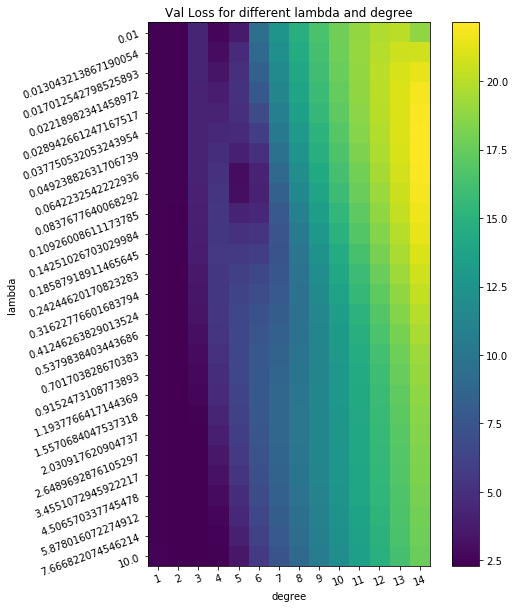

In [21]:
from helper import plot_cv_result
plot_cv_result(np.log((grid_val.T)),search_lambda,search_degree)

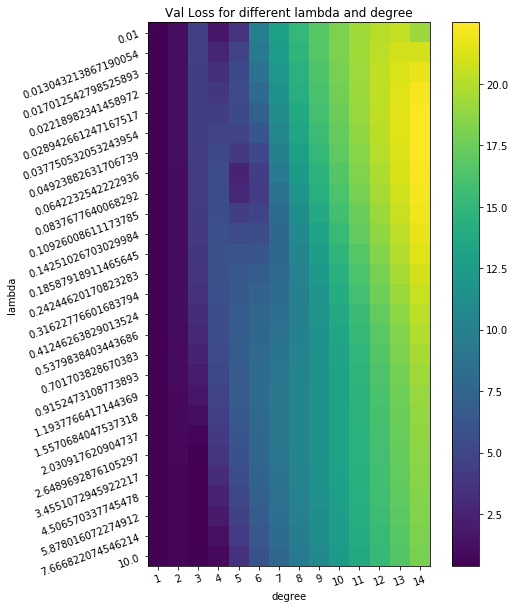

In [22]:
from helper import plot_cv_result
plot_cv_result(np.log((grid_val_std.T)),search_lambda,search_degree)


In [23]:
# best val score
best_score = np.min(grid_val)
print(best_score)

# params which give best val score
d,l= np.unravel_index(np.argmin(grid_val),grid_val.shape)
best_degree = search_degree[d]
best_lambda = search_lambda[l]
print('Best score achieved using degree:{} and lambda:{}'.format(best_degree,best_lambda))


9.910368715513828
Best score achieved using degree:3 and lambda:3.4551072945922217


In [24]:
#Evaluate on the test set
X_train_poly,mu,std = expand_and_normalize_X(X_train,best_degree)
w = get_w_analytical_with_regularization(X_train_poly,y_train,best_lambda)
X_test_poly = expand_X(X_test,best_degree)
X_test_poly[:,1:] =  (X_test_poly[:,1:]-mu)/std

get_loss(w,X_train_poly,y_train,X_test_poly,y_test)

The training loss is 7.06392522895881 with std:13.444314802640736. The test loss is 8.228462752602276 with std:11.38108061204404.


8.228462752602276

**Question**: How can you interpret the linear regression coefficients?

**Answer**: The coefficients value closer to zero means that corresponding features are unimportant for the model. Positive coefficient represent positive correlation with the value to be predicted and similar for negative case.

**Question**: Is it good to have coefficients' values close to zero? 

**Answer**: Having coefficients close to zero means corresponding features are redundant for the model predictions. Hence we can represent our data with smaller feature sets. It might become important, when we might have several thousand features and prune out redundant ones, improving the interpretibility of the model.

**Question**: How would you proceed to improve the prediction?

**Answer**: Better feature expansion. One way would be to choose feature combinations which have high coefficient values. Choosing better hyperparameter. Till now we have done Grid Search, it would better to RandomSearch on the parameter space. Trying out different methods like Random Forest or Neural Nets. 